##Midterm 2 - Assignment 2 (Luca Marini)

In [ ]:
import cv2
import glob
import re
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Images split in training set (TR) and test set (TS) and extraction of SIFT descriptors
I get the images from the dataset and set the 20th image of all classes for the TS.
<br>I obtain the <b>gray scale</b> version of each image, to exploit them to calculate the <b>points of interest</b> and their relative <b>descriptors</b>.

In [ ]:
path_training_images = sorted(glob.glob('/content/drive/MyDrive/MSRC_ObjCategImageDatabase_v1/[1-8]*[!._GMT].bmp')) #get images
path_test_images = [item for item in path_training_images if "_20_s.bmp" in item]
path_training_images[:] = [item for item in path_training_images if "_20_s.bmp" not in item]

#image 0-28 --> class 1
#image 29-57 --> class 2
# ...
#image 203-231 --> class 8

In [ ]:
images_TR = []
images_test = []

num_classes = 8
gray_training_images = []
gray_test_images = []
descriptors_TR = []
key_points_TR = []
descriptors_test = []
key_points_test = []
descriptors_image_TR = []
descriptors_image_test = []
images_TR_class = []
images_test_class = []

sift = cv2.xfeatures2d.SIFT_create()

#get PoI for training and test images
for i, im in enumerate(path_training_images):
  images_TR_class.append(int(im[len('/content/drive/MyDrive/MSRC_ObjCategImageDatabase_v1/') : len('/content/drive/MyDrive/MSRC_ObjCategImageDatabase_v1/') + 1]))
  img = cv2.imread(im)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images_TR.append(img_rgb)

  #get the gray scale version of the image
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_training_images.append(gray)

  #get descriptor and keypoints of the image
  kp, des = sift.detectAndCompute(gray, None)
  descriptors_TR.append(des)
  key_points_TR.append(kp)
  descriptors_image_TR.append(i)

for i, im in enumerate(path_test_images): #as before, but for test images
  images_test_class.append(int(im[len('/content/drive/MyDrive/MSRC_ObjCategImageDatabase_v1/') : len('/content/drive/MyDrive/MSRC_ObjCategImageDatabase_v1/') + 1]))
  img = cv2.imread(im)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images_test.append(img_rgb)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_test_images.append(gray)

  kp, des = sift.detectAndCompute(gray, None)
  descriptors_test.append(des)
  key_points_test.append(kp)
  descriptors_image_test.append(i)

##Run k-means and creation of bag of visual terms (TR)
I run <b>k-means</b> with 2000 clusters and I use the results to create a <b>bag of visual terms</b>.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

#aggregate all the descriptors in a dataset
X = np.concatenate(descriptors_TR)
X.shape

(107205, 128)

In [ ]:
K = 2000

# run k-means
kmeans = KMeans(n_clusters = K, random_state = 0, init = "k-means++", n_init = "auto").fit(X)

In [ ]:
#returns: a list that contains the cluster associated to each key_point

def create_bow(kp, kp_cluster):
  descriptors_cluster = [] #list of the clusters of each descriptor of each image
  dim = 0
  for i in range(len(kp)): #for each image
    util = [] #list of the clusters of each descriptor of the image
    for _ in range(len(kp[i])):
      index = kp_cluster[dim]
      util.append(index)
      dim += 1
    # transform into a list of string
    util = [str(util[i]) for i in range(len(util))]
    descriptors_cluster.append(util)
  return descriptors_cluster

In [ ]:
bow_TR = create_bow(key_points_TR, kmeans.labels_)

##LDA model training and grid search to find the best hyperparameters
At first I create a <b>corpus</b>, that is the stream of documents used for training.
<br>After that I train some <b>LDA models</b> to make a <b>grid search</b> on the number of topics and on the values of alpha, in order to maximize the <b>coherence score</b>. The coherence score is a measure of how the results are good for human interpretation; the more it's high, the better it is.
<br>At the end I retrain the best model with more passes than I set on the grid search (I reduced this value in order to avoid the grid search to take too much time).

In [ ]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [ ]:
# Create a corpus from a list of texts
dictionary_TR = Dictionary(bow_TR)
corpus_TR = [dictionary_TR.doc2bow(text) for text in bow_TR]

In [ ]:
import gensim
from gensim.models import CoherenceModel
from google.colab import output


#grid search
num_topics = [6, 7, 8, 9, 16]
alpha = [0.01, 0.1, 1, 30, 'auto']
chunksize = [10, 100, 150]
iterations = len(num_topics) * len(alpha) * len(chunksize)

max_coherence = 0
#default values
lda = None
best_num_topics = 8
best_update_every = 1
best_chunksize = 100
update = 1
best_alpha = 'auto'
for i in range(len(num_topics)):
  for j in range(len(alpha)):
    for c in range(len(chunksize)):
      #Train the model on the corpus
      lda_util = gensim.models.ldamodel.LdaModel(corpus_TR,
                                            id2word = dictionary_TR,
                                            num_topics = num_topics[i],
                                            random_state = 100,
                                            update_every = best_update_every,
                                            chunksize = chunksize[c],
                                            passes = 20,
                                            alpha = alpha[j],
                                            eta = 'auto',
                                            per_word_topics = True
                                            )
      #value the model based on coherence score
      coherence_model_lda = CoherenceModel(model=lda_util, texts=bow_TR, dictionary=dictionary_TR, corpus=corpus_TR, coherence='c_v')
      coherence_lda = coherence_model_lda.get_coherence()
      output.clear()
      print("update " + str(update) + "/" + str(iterations))
      update += 1
      if(coherence_lda > max_coherence): #keep track of the best model
        lda = lda_util
        max_coherence = coherence_lda
        best_num_topics = num_topics[i]
        best_alpha = alpha[j]
        best_chunksize = chunksize[c]

print()
print("number of topics: " + str(best_num_topics))
print("chunksize: " + str(best_chunksize))
print("alpha: " + str(best_alpha))
print("coherence score: " + str(max_coherence))

update 75/75

7
1
150
0.1
0.5841143521580954


In [ ]:
lda__ = gensim.models.ldamodel.LdaModel(corpus_TR,
                                      id2word = dictionary_TR,
                                      num_topics = best_num_topics,
                                      random_state = 100,
                                      update_every = best_update_every,
                                      chunksize = best_chunksize,
                                      passes = 20,
                                      alpha = best_alpha,
                                      eta = 'auto',
                                      per_word_topics = True
                                      )

In [ ]:
for idx, topic in lda.print_topics(-1):
    print("Topic: {} \nClusters: {}".format(idx, topic))
    print()

Topic: 0 
Clusters: 0.045*"835" + 0.028*"825" + 0.023*"1480" + 0.015*"1042" + 0.015*"603" + 0.014*"1598" + 0.013*"1929" + 0.011*"869" + 0.009*"799" + 0.008*"140"

Topic: 1 
Clusters: 0.004*"1021" + 0.004*"391" + 0.003*"340" + 0.003*"1462" + 0.003*"101" + 0.003*"1794" + 0.003*"1108" + 0.003*"655" + 0.003*"210" + 0.003*"1261"

Topic: 2 
Clusters: 0.006*"353" + 0.005*"249" + 0.005*"140" + 0.004*"1182" + 0.004*"440" + 0.003*"21" + 0.003*"1388" + 0.003*"98" + 0.003*"819" + 0.003*"1104"

Topic: 3 
Clusters: 0.009*"869" + 0.008*"117" + 0.007*"1857" + 0.006*"1941" + 0.005*"1190" + 0.005*"794" + 0.005*"1549" + 0.005*"1095" + 0.005*"552" + 0.004*"1626"

Topic: 4 
Clusters: 0.002*"1416" + 0.002*"549" + 0.002*"31" + 0.002*"1011" + 0.002*"1817" + 0.002*"1759" + 0.002*"1420" + 0.002*"141" + 0.002*"1071" + 0.002*"809"

Topic: 5 
Clusters: 0.018*"544" + 0.016*"467" + 0.015*"387" + 0.014*"1674" + 0.012*"352" + 0.010*"980" + 0.010*"1463" + 0.009*"1139" + 0.008*"526" + 0.007*"673"

Topic: 6 
Clusters: 0.

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# a measure of how good the model is. The lower, the better.
print('Perplexity: ', lda.log_perplexity(corpus_TR))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=bow_TR, dictionary=dictionary_TR, corpus=corpus_TR, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  -7.579421579645984

Coherence Score:  0.5841143521580954


##Test phase
In this phase I first assign a cluster to the descriptors of the <b>TS</b> images; then, as before but using these images, I create a bow and a corpus.
<br>
<br>After that, I show an example of how the model behaves on an image of a certain class compared with the relative test image. I plot the two images, and for each point of interest the associated topic is displayed with its specific color.
<br>
<br>To summarize I calculate the distribution of the topics in each class of images, first on TR then on TS. At the end there is an example of that despite two images of TR can be in the same class, their point of interest could be associated to the topics in a completely different way.

In [ ]:
#run k-means on test data

X_test = np.concatenate(descriptors_test)
kmeans_test = kmeans.predict(X_test)

print(kmeans_test[2000])
print(len(descriptors_test[0]) + len(descriptors_test[1]) + len(descriptors_test[2]) + len(descriptors_test[3]) + len(descriptors_test[4]) + len(descriptors_test[5]) + len(descriptors_test[6]) + len(descriptors_test[7]))
print()

1517
3060



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bow_test = create_bow(key_points_test, kmeans_test)

In [ ]:
# Create a corpus from a list of texts
dictionary_test = Dictionary(bow_test)
corpus_test = [dictionary_test.doc2bow(text) for text in bow_test]

In [ ]:
def topic_distribution(images_corpus, lda_model, dictonary):
  output = list(lda_model[images_corpus])
  clusters = [dictonary[output[1][i][0]] for i in range(len(output[1]))]
  topics = [output[1][i][1][0] for i in range(len(output[1]))]
  output = dict(zip(clusters,topics))
  return output

In [ ]:
def draw_keypoints(img, keypoints, kp_topics):
    colors = {
      0 : (255, 0, 0),
      1 : (100, 0, 0),
      2 : (0,	255,	0),
      3 : (0,	0, 255),
      4 : (0, 100, 0),
      5: (255,	0, 255),
      6: (0,	255, 255),
      7 : (255, 255, 0),
      8 : (0,	0, 50),
      9 : (0, 0, 100),
      10: (0,	0, 175),
      11: (50, 0, 0),
      12: (100,	100, 0),
      13: (175,	0, 0),
      14: (0,	100, 100),
      15 : (0,	175, 0),
      16 : (0, 50, 0)
    }

    for kp, c in zip(keypoints, kp_topics):
        x, y = kp.pt
        image = cv2.circle(img, (int(x), int(y)), color=colors[c], radius=5, thickness=1)

    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [ ]:
def print_overlaid_kp(index, images_corpus, lda_model, id2cluster, data, image_list, PoI_list):
  dic = topic_distribution(images_corpus[index], lda_model, id2cluster)
  topics_list = []
  for i in range(len(data[index])):
    key = str(data[index][i])
    topics_list.append(dic[key])
  draw_keypoints(image_list[index], PoI_list[index], topics_list)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


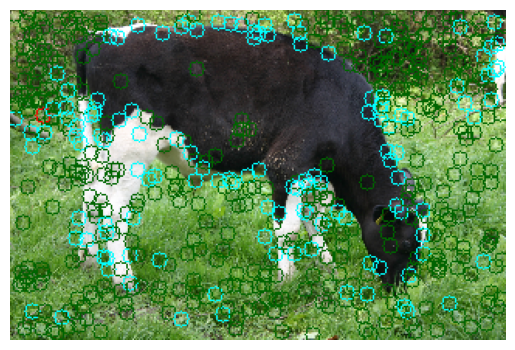

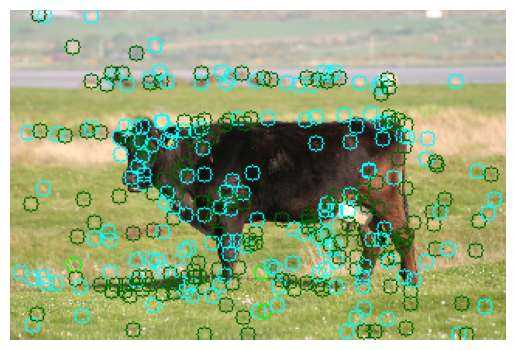

In [ ]:
#plot a TR image of a certain class and the respective image of the same class from the TS
print_overlaid_kp(126, corpus_TR, lda, dictionary_TR, bow_TR, images_TR, key_points_TR)
print_overlaid_kp(4, corpus_test, lda, dictionary_test, bow_test, images_test, key_points_test)

In [ ]:
topics_list_TR = []
for i in range(len(images_TR)):
  dic = topic_distribution(corpus_TR[i], lda, dictionary_TR)
  topics = []
  for j in range(len(bow_TR[i])):
    key = str(bow_TR[i][j])
    topics.append(dic[key])
  topics_list_TR.append(topics)

topics_list_test = []
for i in range(len(images_test)):
  dic = topic_distribution(corpus_test[i], lda, dictionary_test)
  topics = []
  for j in range(len(bow_test[i])):
    key = str(bow_test[i][j])
    topics.append(dic[key])
  topics_list_test.append(topics)


distribution_TR = []
topics_counter = []
for i in range(len(images_TR)): # for each image
  counter = [0] * best_num_topics
  for j in range(len(topics_list_TR[i])): #for each descriptor in the image
    counter[topics_list_TR[i][j]] += 1
  topics_counter.append(counter)

  distribution = []
  for r in range(best_num_topics):
    distribution.append(topics_counter[i][r] * 100 / len(topics_list_TR[i]))
  distribution_TR.append(distribution)

distribution_test = []
topics_counter_test = []
for i in range(len(images_test)): # for each image
  counter = [0] * best_num_topics
  for j in range(len(topics_list_test[i])): #for each descriptor in the image
    counter[topics_list_test[i][j]] += 1
  topics_counter_test.append(counter)

  distribution = []
  for r in range(best_num_topics):
    distribution.append(topics_counter_test[i][r] * 100 / len(topics_list_test[i]))
  distribution_test.append(distribution)



In [ ]:
topic_class_distribution = []
for c in range(num_classes):
  distr = [0] * best_num_topics
  for i in range(len(topics_counter)):
    if images_TR_class[i] == c + 1:
      distr = np.add(distr, topics_counter[i])
  topic_class_distribution.append(distr)

for i in range(len(topic_class_distribution)):
  distr = []
  for j in range(len(topic_class_distribution[i])):
    distr.append(topic_class_distribution[i][j] * 100 / np.sum(topic_class_distribution[i]))
  topic_class_distribution[i] = distr

for i in range(len(topic_class_distribution)):
  best_topic = topic_class_distribution[i].index(max(topic_class_distribution[i]))

  print(topic_class_distribution[i])
  print("MOst common topic: " + str(best_topic + 1))
  print()

[0.0, 3.3603114434996413, 5.440016391763139, 4.056961376908104, 50.496875320151624, 0.0, 36.64583546767749]
MOst common topic: 5

[0.006178942165101334, 6.141868512110727, 3.064755313890262, 1.680672268907563, 78.719723183391, 0.1791893227879387, 10.207612456747405]
MOst common topic: 5

[1.198224852071006, 0.27366863905325445, 8.372781065088757, 16.087278106508876, 25.14792899408284, 8.565088757396449, 40.35502958579882]
MOst common topic: 7

[0.0, 0.0, 11.799252536038441, 21.42285104111052, 0.14682327816337426, 0.0, 66.63107314468766]
MOst common topic: 7

[0.007024938531787847, 1.0748155953635405, 0.8991921320688444, 7.0460133473832105, 52.680014049877066, 0.0, 38.292939936775554]
MOst common topic: 5

[0.278468423669816, 7.3893585280954746, 8.294380905022377, 13.76429636996519, 12.073595226255595, 0.0, 58.19990054699154]
MOst common topic: 7

[0.15109163707788775, 0.0, 24.665709752965174, 16.091259348795045, 5.7943642819369945, 0.0, 53.2975749792249]
MOst common topic: 7

[3.758637

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for i in range(len(distribution_test)):
  best_topic_test = distribution_test[i].index(max(distribution_test[i]))

  print(distribution_test[i])
  print("MOst common topic: " + str(best_topic_test + 1))
  print()

[0.0, 0.0, 0.0, 49.19786096256684, 4.81283422459893, 0.0, 45.98930481283423]
MOst common topic: 4

[0.0, 0.0, 0.0, 2.72572402044293, 17.88756388415673, 0.0, 79.38671209540034]
MOst common topic: 7

[0.0, 0.0, 3.910614525139665, 3.910614525139665, 56.98324022346369, 0.0, 35.19553072625698]
MOst common topic: 5

[0.0, 0.0, 0.3875968992248062, 0.0, 68.21705426356588, 0.0, 31.3953488372093]
MOst common topic: 5

[0.0, 0.0, 0.7936507936507936, 0.0, 48.148148148148145, 0.0, 51.05820105820106]
MOst common topic: 7

[0.0, 16.574585635359117, 0.0, 0.0, 39.226519337016576, 0.0, 44.19889502762431]
MOst common topic: 7

[0.0, 0.0, 2.1052631578947367, 2.456140350877193, 49.824561403508774, 0.0, 45.6140350877193]
MOst common topic: 5

[0.0, 0.0, 14.166666666666666, 1.1111111111111112, 63.75, 0.0, 20.97222222222222]
MOst common topic: 5



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


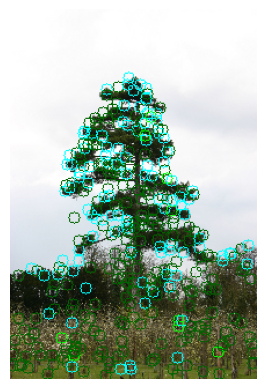

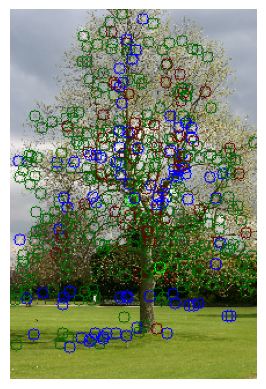

In [ ]:
#plot two TR images of the same class
print_overlaid_kp(33, corpus_TR, lda, dictionary_TR, bow_TR, images_TR, key_points_TR)
print_overlaid_kp(30, corpus_TR, lda, dictionary_TR, bow_TR, images_TR, key_points_TR)

##Results and final consideration
Some hyperparameters of the model were not explored to the reported grid search; this has been done to ease the search, so that it didn't take too much time. The values for these hyperparameter and the choice of the values explored in the grid search for the number of topics, the chunksize, and alpha were chosen by doing some preliminar experiments, always with the aim to maximize the coherence score. The number of cluster, (K = 2000) were set with the same method and for the same goal.
<br>
<br>The result shows different outcomes for different classes and images. In fact we can see that the distribution of the topics in the TS images are very different from the one in TR images. In fact, we see cases were there is a spatial and semantic correspondance between TS and TR images (like in the first example with the cow), and other cases where the topics don't match. This can be due to the fact that some images have a complex structure (e.g.: a lot of features in the background that should be weighted less) that cause problems to the model. Moreover, as we can see from the last example with trees, even if two TR images belong to the same class, it may be the case that the semantic of the point of interest is completely different. This may be coused by the fact that even if the images represent the same kind of object, they don't always represent the exact same object; so, even if we have trees, a different type of leaf could change everything. This non-homogeneity is present in all the dataset and has an influence on the results.
<br>Another important aspect to enlight is that the topic semantics learned by the algorithm is not always easy to understand for humans. In fact, altough some topics has an easier interpretation (thanks to spatial location of the points, like in the cow example), others could be very puzzling to understand. This make the interpretaion of the results to be very difficoult to be made in an objective and unique way.